<a href="https://colab.research.google.com/github/kofibeans/APM1111---SA2/blob/main/AQUINO_SA2_3_Car_Mileage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Car's Mileage: Repeated Measures ANOVA**

**Data Description**

Researchers are curious to know if four different engine oils lead to different mileage of cars. To test this, they measured the mileage of 5 cars using four different engine oils. Since each car’s mileage is measured by applying each of the four-engine oils one by one they use a repeated-measures ANOVA to check if the mean reaction time differs between engine oils.

They then analyze it using AnovaRM to generate the results. Below is their initial code.

```
import numpy as np
import pandas as pd
from statsmodels.stats.anova import AnovaRM
  
# Create the data
dataframe = pd.DataFrame({'Cars': np.repeat([1, 2, 3, 4, 5], 4),
                          'Oil': np.tile([1, 2, 3, 4], 5),
                          'Mileage': [36, 38, 30, 29,
                                      34, 38, 30, 29,
                                      34, 28, 38, 32,
                                      38, 34, 20, 44,
                                      26, 28, 34, 50]})

```

**Directions**
1.	Provide a full analysis using repeated-measures ANOVA to determine if there is a difference in mileage of cars between four engine oils.
2.	Check the assumptions underlying the said ANOVA type.
3.	Make a report in APA format, including the checking of the assumptions.
4.	Provide a Github link to your file answering this problem. (5 points will be automatically deducted if without a Github link.)

*Note*:
*	Use Jupyter Notebook or R Studio with the proper formatting of your markdown and code. You may check your results using JASP.
*	Upload a Word file containing your Github link to your file or upload your R output or Python output using the tool below.
*	Be sure that your outputs/files already contain the results of your analysis and I don't have to run your code to check the output results. (Minus 5 if I still have to run your code to check your outputs.)


## **Exploratory Data Analysis**

### **Environment Set-up**

The following code is written in Python. The libraries are pre-written functionality to perform necessary tasks.

In [31]:
# import libraries

# general setup and libraries
import io
import os  # os-related functionalities
import numpy as np  # numerical computation
import pandas as pd  # data manipulation and statistical analysis
import pingouin as pg

# data visualization
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # data visualization based on matplotlib
import pprint
import IPython
from IPython.display import HTML, display # pretty printing of dataframes in Jupyter notebook

# statistical models and testing
import statsmodels.formula.api as smf  # statistical models using formulas
import statsmodels.api as sm  # statistical models and hypothesis testing
from statsmodels.stats.anova import AnovaRM  # repeated measures ANOVA
from scipy import stats  # scientific computing and statistical functions

# misc libraries
import random
import time

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


### **Data Preparation**

#### **Import Data**

In [2]:
path = 'https://raw.githubusercontent.com/kofibeans/APM1111---SA2/main/car_mileage.csv'

def load(path, info = True):
  if len(path.split(".csv")) > 1:
    read = pd.read_csv(path)
  elif len(path.split(".xlsx")) > 1:
    read = pd.read_excel(path)

  if info:
    if len(read) > 0:
      print("# Dimensions")
      print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")
      print("# Dtypes")
      if len(read.select_dtypes("object").columns) > 0:
        print("-- Object Variables: ",
        len(read.select_dtypes("object").columns), " ",
        read.select_dtypes("object").columns.tolist(), "")

      if len(read.select_dtypes("integer").columns) > 0:
        print("-- Integer Variables: ",
        len(read.select_dtypes("integer").columns), " ",
        read.select_dtypes("integer").columns.tolist(), "")

      if len(read.select_dtypes("float").columns) > 0:
        print("-- Float Variables:",
        len(read.select_dtypes("float").columns), " ",
        read.select_dtypes("float").columns.tolist(), "")

      if len(read.select_dtypes("bool").columns) > 0:
         print("-- Bool Variables:",
        len(read.select_dtypes("bool").columns), " ",
        read.select_dtypes("bool").columns.tolist(), "")

      print("\n# Missing Value")
      print("-- Are there any missing values? ", np.where(read.isnull().values.any() == False, "[No missing value!]", "[Data includes missing value!]"), "\n")
      buf = io.StringIO()
      read.info(buf=buf)
      info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
      print("# Memory Usage: ", info, "\n")

    else:
      print("# Data did not import!")

  return read

data = load(path, info = True)

# Dimensions
Observation: 20 Column: 4 

# Dtypes
-- Integer Variables:  4   ['Unnamed: 0', 'Cars', 'Oil', 'Mileage'] 

# Missing Value
-- Are there any missing values?  [No missing value!] 

# Memory Usage:  768.0 bytes 



In [3]:
# drop column
data.drop(data.columns[[0]], axis=1, inplace=True)

### **Descriptive Statistics**

In [17]:
des_stat = data.describe(include = 'all')
des_stat.style.set_precision(2)

,Cars,Oil,Mileage
count,20.00,20.00,20.00
mean,3.00,2.50,33.50
std,1.45,1.15,6.64
min,1.00,1.00,20.00
25%,2.00,1.75,29.00
50%,3.00,2.50,34.00
75%,4.00,3.25,38.00
max,5.00,4.00,50.00


## **Assumption Check**

The assumptions based on the data analysis done so far need to be validated further before taking appropriate actions.

### **Assumptions 1 - 2**

**Assumption #1.** Your **dependent variable** should be measured at the **continuous** level (i.e., they are either interval or ratio variables).

> The dependent variable is the *mileage* of the car.

**Assumption #2.** Your independent variable should consist of at least two categorical, "related groups" or "matched pairs"

> The independent factors are the *oils* of the cars.


### **Assumption 3: Outliers**

There should be no significant outliers in the groups of your independent variable in terms of the dependent variable.

####**Outlier Detection Through Box-plot**

To visually inspect outliers through box-plots, observe the points beyond the "whiskers" of the boxplot.

<Axes: xlabel='Oil', ylabel='Mileage'>

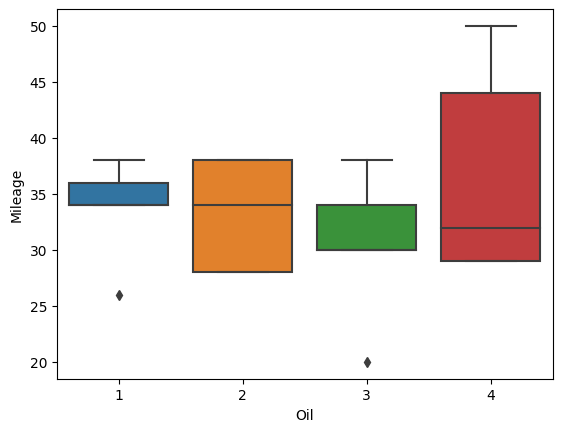

In [26]:
sns.boxplot(x = 'Oil', y = 'Mileage', data = data)

####**Outlier Detection Through z-score**

To identify outliers using the z-score, we can set a threshold value by 3. Data points with a z-score greater than 3 or less than -3 can be considered an *extreme* outlier.

In [29]:
from scipy.stats import zscore

def identify_outliers(group):
    z_scores = zscore(group['Mileage'])
    outliers = (z_scores > 3) | (z_scores < -3)
    return group[outliers]

outliers = data.groupby(['Oil']).apply(identify_outliers)

# display the styled df
outliers.style

,,Cars,Oil,Mileage
Oil,,,,



> ***Remark.*** There were no extreme outliers.

### **Assumption 4: Normality**


In [33]:
result_norm = pg.normality(data=data, dv='Mileage', group='Oil')
result_norm.style

,W,pval,normal
Oil,,,
1,0.859908,0.227920,True
2,0.814320,0.105474,True
3,0.932799,0.615581,True
4,0.833279,0.147184,True



> The data was normally distributed (p \> 0.05), as assessed by Shapiro-Wilk's test of normality.

### **Assumption 5: Sphericity**


In [50]:
# mauchly’s test of sphericity
r_mt = pg.sphericity(data=data, dv='Mileage', subject='Cars', within=['Oil'])
df = pd.DataFrame(r_mt).T
df.style

,0,1,2,3,4
0,True,0.287410,3.394192,5,0.658963


> From the output above, it can be seen that the p-value (0.659) is good, and the test therefore indicates that there is no violation of sphericity.

## **ANOVA Testing and Computation**

In [57]:
print(AnovaRM(data = data, depvar = 'Mileage', subject='Cars', within=['Oil']).fit())

              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
Oil  0.5679 3.0000 12.0000 0.6466



## **Reporting**

A one-way repeated measures ANOVA was conducted to determine if there is a difference in mileage of cars between four engine oils. There was a significant effect of diet on mileage at the p < .05 level for the four engine oils [F(3, 12) = 0.568, p = 0.647].